# notebook to test scat transform

In [23]:
import tensorflow as tf
import os, sys, time, subprocess, h5py, argparse, logging
import numpy as np
from os.path import join as oj
from libs.scattering import scattering
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10, 12)

with h5py.File('data/cifar_100/train.h5') as f:
    ims_orig = f['X'][0:2]

ims = np.transpose(ims_orig, (0, 3, 1, 2))  # convert NHWC -> NCHW
im_shape = ims.shape[1:]
print('ims.shape before NCHW', ims.shape)

# can only run on a gpu
# requires NCHW format (cuDNN default - tf is NHWC)
placeholder = tf.placeholder(tf.float32, (None,) + im_shape)
# M, N: input image size
M, N = placeholder.shape.as_list()[-2:]
J = 4 # spatial scale of filter
print("M", M, "N", N, "J", J)
scat = scattering.Scattering(M=M, N=N, J=J)(placeholder)
print('scat.shape after NCHW', scat.shape)

# M, N = scat.shape.as_list()[-2:]
# scat2 = scattering.Scattering(M=M, N=N, J=J)(scat)
s = scattering.Scattering(M=M, N=N, J=J)
# scat_filter = s.Psi[0][0]
scat_filter = s.Phi[0]

ims.shape before NCHW (2, 3, 32, 32)
M 32 N 32 J 4
scat.shape after NCHW (?, 1251, 2, 2)


In [3]:
with tf.device("/cpu:0"):
    init = tf.global_variables_initializer()
    sess = tf.Session()
    sess.run(init)
    t = time.time()
    [scat_eval, scat2_eval] = sess.run([scat, scat2], feed_dict={placeholder: ims})
    s_eval = sess.run(scat_filter)
    print('scat shape', scat.shape)
    print('scat2 shape', scat2.shape)
    print('time_elapsed', str(time.time() - t))
# convert NCHW -> NHWC
features_new = np.transpose(scat_eval, (0, 2, 3, 1))
features_new2 = np.transpose(scat2_eval, (0, 2, 3, 1))
print('new shapes', features_new.shape, features_new2.shape)

scat shape (?, 27, 16, 16)
scat2 shape (?, 243, 8, 8)
time_elapsed 0.3925507068634033
new shapes (5, 16, 16, 27) (5, 8, 8, 243)


features_new.shape (5, 16, 16, 27)


TypeError: Invalid dimensions for image data

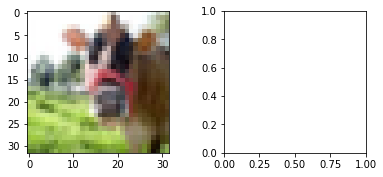

In [11]:
features_summed = np.sum(features_new, axis=3)
features_summed2 = np.sum(features_new2, axis=3)
print('features_new.shape', features_new.shape)
ROWS = 4
N = 3
plt.subplot(ROWS,N,1)
plt.imshow(ims_orig[0])
plt.grid(False)
plt.subplot(ROWS,N,2)
plt.imshow(features_new[0, :, :])
plt.subplot(ROWS,N,3)
plt.imshow(features_summed2[0, :, :])
plt.show()

In [62]:
print("M", M, "N", N, "J", J)
s = scattering.Scattering(M, N, J)
psi = scat.Psi
phi = scat.Phi

M 16 N 16 J 1


AttributeError: 'Tensor' object has no attribute 'Psi'

In [36]:
np.array(psi[0][0])

array(<tf.Tensor 'psi_theta0_j0_12:0' shape=(20, 20, 2) dtype=float32>, dtype=object)

In [48]:
scat_filters.Psi[0][0]

<tf.Tensor 'psi_theta0_j0_23:0' shape=(20, 20, 2) dtype=float32>

(20, 20, 2)

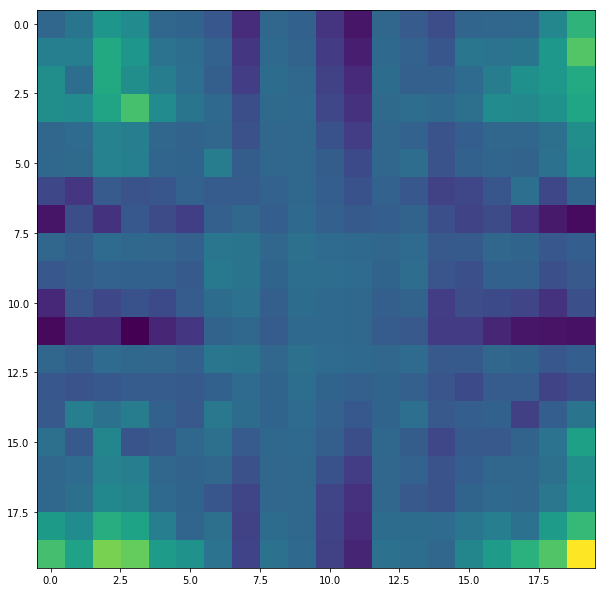

In [68]:
plt.imshow(s_eval[:, :, 1])
s_eval.shape